In [2]:
import os
import glob
import time
from datetime import datetime

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.6.0


# CIFAR-10 이미지 생성하기
- 이미지 데이터의 shape가 (28, 28, 1)에서 (32, 32, 3)으로 변경
- 이미지가 단색의 grayscale에서 RGB 3채널의 컬러이미지로 변경


# STEP 1. 작업환경 구성하기


# STEP 2. 데이터셋 구성하기
1. 학습에 사용할 train_x의 이미지를 -1, 1로 정규화
1. 로드한 학습 데이터를 시각화
1. tf.data.Dataset 모듈의 from_tensor_slices() 함수를 사용하여 미니배치 데이터셋을 구성

In [3]:
# data set label
LABEL = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
         'dog', 'frog', 'horse', 'ship', 'truck']

cifar_10 = tf.keras.datasets.cifar10
(train_x, train_y), (test_x, _) = cifar_10.load_data()
print(train_x.shape)


(50000, 32, 32, 3)


In [4]:
# 최대, 최솟값
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())
print('\n')

# scale 계산
max_train_x = train_x.max()
min_train_x = train_x.min()
num_normal = (max_train_x - min_train_x) / 2

# 이미지를 [-1, 1]로 정규화합니다.
train_x_normal = train_x / num_normal - 1 
print("max pixel:", train_x_normal.max())
print("min pixel:", train_x_normal.min())

# train data shape
# train_x_normal = train_x_normal.astype('float32')
print('train_x_normal.shape : ', train_x_normal.shape)


max pixel: 255
min pixel: 0


max pixel: 1.0
min pixel: -1.0
train_x_normal.shape :  (50000, 32, 32, 3)


frog


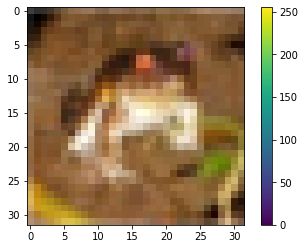

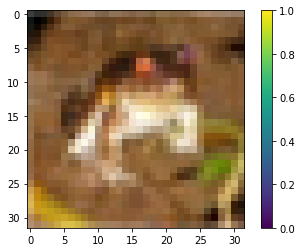

In [5]:
# train data 확인
print(LABEL[train_y[0][0]])

plt.imshow(train_x[0])
plt.colorbar()
plt.show()

img_color = (train_x_normal[0] + 1) / 2 
plt.imshow(img_color)
plt.colorbar()
plt.show()


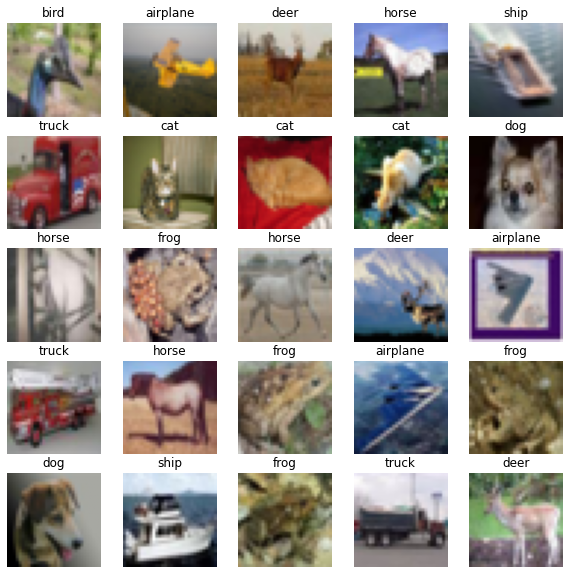

In [6]:
# train data 확인 (random 25개)
num_random = 25
len_x = len(train_x)

sample_name = []
sample_img = []
for idx in range(num_random):
    idx_random = np.random.randint(1,len_x)
    img_ = (train_x_normal[idx_random]+1)/2
    sample_name.append(train_y[idx_random][0])
    sample_img.append(img_)

fig = imshow_plot(sample_img, 5)
axes_ = fig.get_axes()
for idx, el_axe in enumerate(axes_):
    idx_name = sample_name[idx]
    el_axe.set_title(LABEL[idx_name])
    el_axe.axis('off')
set_size_fig(fig, 10, 10)
plt.show()


In [7]:
BUFFER_SIZE = len_x
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(train_x_normal).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


# STEP 3. 생성자 모델 구현하기
1. (32, 32, 3) 이미지 생성자 모델 구현 함수 작성
1. tf.random.normal([1, 100]), 랜덤 노이즈를 입력
1. 생성자로 랜덤 이미지를 생성
1. 생성된 랜덤 이미지가 생성자 출력 규격에 잘 맞는지 확인

In [8]:
# 생성자 모델 생성
def make_generator_model():
    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    #개선
    #model.add(layers.Dropout(0.5))

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    #개선
    #model.add(layers.Dropout(0.5))

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    #개선
    #model.add(layers.Dropout(0.5))

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))
    
    #
    # model.add(PixelShuffler(size=(1, 1)))

    return model

generator = make_generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 32, 32, 3)


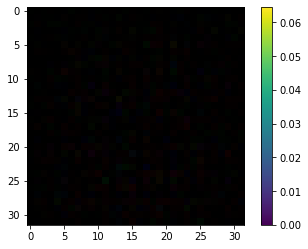

In [9]:
#shape=(1, 100) 랜덤 노이즈 벡터로 결과물 생성
# tf.random.normal : 가우시안 분포에서 뽑아낸 랜덤 벡터로 이루어진 노이즈 벡터를 만듬
noise = tf.random.normal([1, 100])

# 레이어와 모델에 call 메소드를 구현되어 있음
# 생성자 모델의 입력값으로 노이즈를 넣고 바로 모델을 호출
# 결과 이미지 반환 (내부적으로는 생성자의 call 함수가 호출)
# 지금은 학습하는 중이 아니니 training=False를 설정
# 생성된 출력 이미지
generated_image = generator(noise, training=False)
print(generated_image.shape)

# 생성 이미지 출력
# 모델이 전혀 학습하지 않은 상태, 의미가 없는 노이즈 이미지 생성
plt.imshow(generated_image[0, :, :, ])
plt.colorbar()
plt.show()

# STEP 4. 판별자 모델 구현하기
1. 1dim 판별 결과를 출력하는 판별자 모델 구현 함수 작성
1. 위 STEP 2에서 생성한 랜덤 이미지를 판별자 모델이 판별한 결과값을 확인

In [10]:
# 판별자 모델 생성
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    # 개선
    #tf.keras.layers.MaxPool2D()
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    # 개선
    #tf.keras.layers.MaxPool2D()
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

discriminator = make_discriminator_model()
discriminator.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)             

In [11]:
# generated_image 판별
decision = discriminator(generated_image, training=False)
print(decision)


tf.Tensor([[0.00306042]], shape=(1, 1), dtype=float32)


# STEP 5. 손실함수와 최적화 함수 구현하기
1. 생성자와 판별자의 손실함수(loss)를 구현
1. 판별자의 출력값을 가지고 실제/생성(real/fake) 이미지 판별 정확도(accuracy)를 계산하는 함수를 구현
1. 생성자와 판별자를 최적화하는 optimizer를 정의

In [12]:
# entropy class 내부에서 판별자 출력값 0~1 정규화
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# loss function 설계
# generator_loss는 fake_output가 1에 가까워지기를 바람
# tf.ones_like와 fake_output의 교차 엔트로피값을 계산
# fake_output의 값이 1에 가까울수록 작은 값을 가짐
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# discriminator_loss는 real_loss + fake_loss
# real_output가 1에 가까워지기를 바람
# fake_output가 0에 가까워지기를 바람
# 각각 교차 엔트로피값을 계산
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

# 판별자가 real output, fake output을 얼마나 정확히 판별하는지의 accuracy를 계산
# accuracy가 1이면 fake output이 진짜같은 결과를 생성하지 않고 있다는 것
# 초반에는 1.0에 가깝게 나오다가, 서서히 낮아져서 둘 다 0.5에 가까워지는 것이 이상적
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy


In [13]:
# optimizer function 설계

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# 개선
#learning_rate = 1e-3
#learning_rate = 5e-4
#generator_optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate, 
#                                                   beta_1 = 0.9, beta_2 = 0.999)
#discriminator_optimizer = tf.keras.optimizers.SGD(learning_rate)


In [14]:
# 학습 진행 테스트
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
print(seed.shape)


(16, 100)


# STEP 6. 훈련과정 상세 기능 구현하기
1. 1개 미니배치의 훈련 과정을 처리하는 train_step() 함수를 구현
1. 16개의 고정된 seed를 입력, 훈련 과정 동안 생성한 이미지를 시각화하는 generate_and_save_images() 함수를 구현
1. 훈련 epoch마다 생성자/판별자의 loss 및 판별자의 실제/생성(real/fake) 이미지 판별, accuracy 히스토리(history)를 그래프로 시각화하는 draw_train_history() 함수를 구현
1. training_checkpoints 디렉토리에 몇 epoch마다 모델을 저장하는 checkpoint 모듈을 설정


In [15]:
@tf.function
#(1) 입력데이터
def train_step(images):
    #(2) 생성자 입력 노이즈
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  

    #(3) tf.GradientTape() 오픈 : 자동 Gradient 계산 (미분)
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  
        #(4) generated_images 생성
        generated_images = generator(noise, training=True)  

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산 : discriminator의 정확도 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    #(10) 리턴값
    return gen_loss, disc_loss, real_accuracy, fake_accuracy


In [16]:
# predict, save image
def generate_and_save_images(path_dir, model, epoch, it, sample_seeds):
    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')
    plt.savefig(path_dir + 'sample_epoch_{:04d}_iter_{:03d}.png'.format(epoch, it))
    plt.show()

In [17]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

# history 출력
def draw_train_history(path_dir, history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    # plt.savefig('./exploration/exploration_10/project/training_history/train_history_{:04d}.png'
    #               .format(epoch))
    plt.savefig(path_dir + 'train_history_{:04d}.png'.format(epoch))
    plt.show()


In [18]:
def createFolder(path_dir):
    try:
        if not os.path.exists(path_dir):
            os.makedirs(path_dir)
    except OSError:
        print ('Error: Creating directory. ' +  path_dir)

def get_date_for_path():
    return str(datetime.now().strftime("%m%d%H%M%S"))


In [19]:
path_log = './test_log/test_' + get_date_for_path() + '/'
createFolder(path_log)

checkpoint_dir = path_log + 'training_checkpoints/'
createFolder(checkpoint_dir)
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [20]:
# train
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    # make dir for sample  
    path_dir_sample = path_log + 'gen_sample/'
    createFolder(path_dir_sample)
    path_dir_history = path_log + 'train_history/'
    createFolder(path_dir_history)

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(path_dir_sample, generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(path_dir_sample, generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(path_dir_history, history, epoch)


# STEP 7. 학습 과정 진행하기
1. 위 STEP 5에서 구현한 기능들을 활용하여 최소 50 epoch만큼의 모델 학습을 진행
1. 학습 과정에서 생성된 샘플 이미지로 만든 gif 파일을 통해 학습 진행 과정을 시각적으로 표현
1. 학습 과정을 담은 샘플 이미지, gif 파일, 학습 진행 그래프 이미지를 함께 제출

In [21]:
save_every = 5
EPOCHS = 200

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

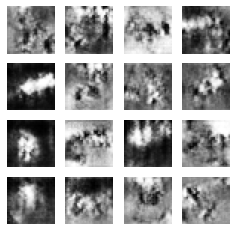

Time for training : 4333 sec


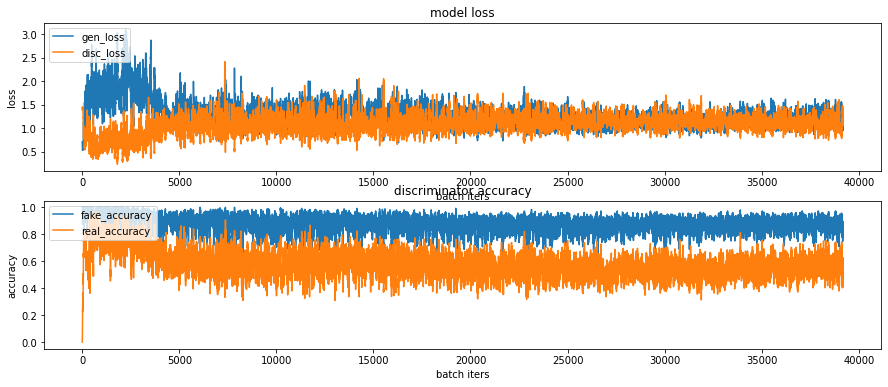

CPU times: user 1h 12min 26s, sys: 5min, total: 1h 17min 27s
Wall time: 1h 12min 15s


In [22]:
%%time
train(train_dataset, EPOCHS, save_every)


# STEP 8. (optional) GAN 훈련 과정 개선하기
STEP 6을 진행하면서 생성된 샘플 이미지, 학습 과정 그래프 등을 통해 이전 훈련 과정의 문제점을 분석해 봅시다.
모델구조 또는 학습 과정을 개선한 내역과 그 결과(샘플 이미지, 학습 과정 그래프 포함)를 함께 제출합니다.

// 개선
- 생성자 : model.add(layers.Dropout(0.5)) 추가
- 판별자 : tf.keras.layers.MaxPool2D() 추가
- learning_rate = 5e-4
    - generator_optimizer = tf.keras.optimizers.Adam(learning_rate)
    - discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate)

In [ ]:
# 생성자 모델 생성
def make_generator_model():
    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    #개선
    model.add(layers.Dropout(0.5))

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    #개선
    model.add(layers.Dropout(0.5))

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    #개선
    model.add(layers.Dropout(0.5))

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))
    
    #
    # model.add(PixelShuffler(size=(1, 1)))

    return model

generator = make_generator_model()
generator.summary()

In [ ]:
# 판별자 모델 생성
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    # 개선
    tf.keras.layers.MaxPool2D()
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    # 개선
    tf.keras.layers.MaxPool2D()
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

discriminator = make_discriminator_model()
discriminator.summary()


# 개선 후 결과
epoch = 1000

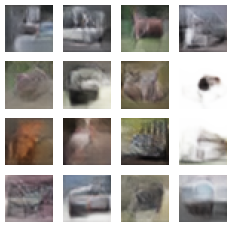

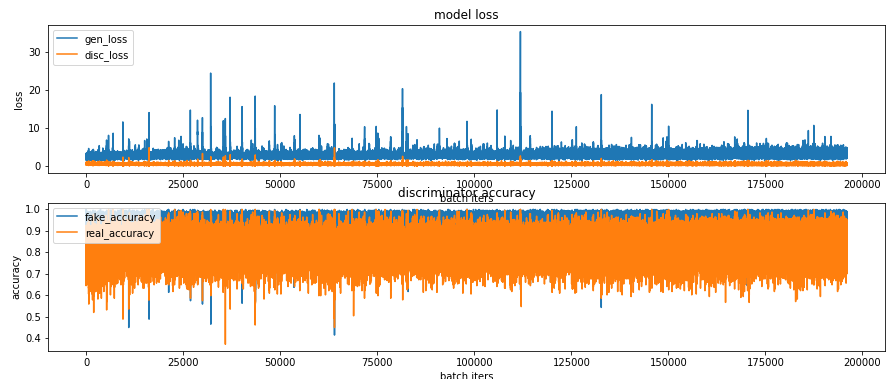

- epoch가 증가할 수록 향상된 이미지를 보이지만 fake accuracy의 max는 줄어들지 않음,
- 판별자의 학습이 별도로 필요한것 같다


- 판별자 optimizer를 SGD로 바꿔도 보았지만 fake accuracy가 1에서 고정되어 내려오지 않음
- label을 사용하여 학습하는 방법을 해볼 필요가 있음
    - label에 noise를 주는법
    - label로 판별자를 사전 학습시키는법
    
